In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def visualize_data(df, rows=None):
    df_corr = df.corr()
    print(df_corr.head(10))

    data = df_corr.values
    
    if rows is not None:
        data = data[rows].reshape(len(rows), data.shape[1])
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    heatmap = ax.pcolor(data, cmap=plt.cm.RdYlGn)
    fig.colorbar(heatmap)

    ax.set_xticks(np.arange(data.shape[0]), minor=False)
    ax.set_yticks(np.arange(data.shape[1]), minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    plt.xticks(rotation=90)
    heatmap.set_clim(-1, 1)
    plt.tight_layout()
    plt.show()

In [3]:
# Load the data
data = pd.read_csv('34933-0001-Data.tsv', sep='\t', header=0)
print(data.shape)
print(data.head())
# check for missing values
print(data[np.isinf(data.values).any(axis=1)])
print(data[np.isnan(data.values).any(axis=1)])

(55268, 3120)
   CASEID  QUESTID2  CIGEVER  CIGOFRSM  CIGWILYR  CIGTRY  CIGYFU  CIGMFU  \
0       1  50886467        2         4         4     991    9991      91   
1       2  13766883        2        99        99     991    9991      91   
2       3  17772877        2        99        99     991    9991      91   
3       4  45622817        1        99        99      13    9999      99   
4       5  17239390        1        99        99      11    9999      99   

   CIGREC  CIG30USE  ...  IIEMPSTY  II2EMSTY  EMPSTAT4  IIEMPST4  II2EMST4  \
0      91        91  ...         1         1        99         9         9   
1      91        91  ...         1         1         1         1         1   
2      91        91  ...         1         1         1         1         1   
3       2        93  ...         1         1         2         1         1   
4       4        93  ...         1         1         1         1         1   

   PDEN00  COUTYP2      ANALWT_C  VESTR  VEREP  
0       2  

We start by selecting the columns that will be our features and the columns that will be our labels.

In [4]:
# clean the data up
features = ["IRWELMOS", "IRFAMIN3", "NOMARR2", "HEALTH", "IRSEX", "IREDUC2", "NEWRACE2", "MOVESPY2", "JBSTATR2"]
labels = ["COCEVER", "HEREVER", "LSD", "AMYLNIT", "DARVTYLC"]

data_selection = data[features]
labels_selection = data[labels]

We then process our labels so that if someone has ever used cocaine, heroin, LSD, inhalants or non prescribed prescription
pain pills, the will be marked as a hard drug user.

In [5]:
# process labels
# COCAINE
labels_selection.loc[labels_selection['COCEVER'] != 1, 'COCEVER'] = 0

# HEROIN
labels_selection.loc[labels_selection['HEREVER'] != 1, 'HEREVER'] = 0

# HALLUCINOGENS
labels_selection.loc[labels_selection['LSD'] != 91, 'LSD'] = 1
labels_selection.loc[labels_selection['LSD'] == 91, 'LSD'] = 0

# INHALANTS
labels_selection.loc[labels_selection['AMYLNIT'] != 91, 'AMYLNIT'] = 1
labels_selection.loc[labels_selection['AMYLNIT'] == 91, 'AMYLNIT'] = 0

# PAIN RELIEVERS
labels_selection.loc[(labels_selection["DARVTYLC"] == 91) | (labels_selection["DARVTYLC"] == 81), 'DARVTYLC'] = 0
labels_selection.loc[(labels_selection["DARVTYLC"] != 0), 'DARVTYLC'] = 1

labels = np.zeros((labels_selection.shape[0], 1))
for i, row in enumerate(labels_selection.iterrows()):
    if 1 in list(row[1].values):
        labels[i] = 1
        
print(labels[:20])
print(labels_selection.head(20))

[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]
    COCEVER  HEREVER  LSD  AMYLNIT  DARVTYLC
0         0        0    0        0         0
1         0        0    0        0         0
2         0        0    0        0         0
3         1        0    1        0         0
4         0        0    0        0         0
5         0        0    0        0         0
6         0        0    0        0         0
7         0        0    0        0         0
8         0        0    0        0         0
9         1        1    1        0         1
10        0        0    0        0         0
11        0        0    0        0         0
12        0        0    0        0         0
13        0        0    0        0         1
14        0        0    0        0         0
15        0        0    0        0         0
16        0        0    0        0         0
17        0        0    0        0         0
18        0        0    

## Metric Choice
In our experiments, we evaluate the performance using three metrics: accuracy, ROCAUC, and F1 score. While accuracy is commonly used, it may not be reliable, particularly in scenarios with imbalanced classes where high accuracy can mask poor real-life performance. Therefore, we prioritize the use of ROCAUC and, more importantly, the F1 score. 

## One Hot Encoding
Given that all our features are categorical variables, a common approach would be to apply one-hot encoding to transform them. However, it may not be the optimal choice considering we are utilizing decision tree-based models such as XGBoost and Random Forest. We delve into this topic further in the conclusion of this notebook, addressing the potential issues associated with one-hot encoding in our modeling approach. For now, we will proceed with experimenting by applying one-hot encoding to our variables.

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder(categories='auto')
x = onehotencoder.fit_transform(data_selection.values).toarray()

# shuffle the data
order = np.arange(x.shape[0])
np.random.shuffle(order)
x = x[order]
y = labels[order]

train_data = x[:int(x.shape[0] * 0.8)]
test_data = x[int(x.shape[0] * 0.8):]

train_labels = y[:int(x.shape[0] * 0.8)]
test_labels = y[int(x.shape[0] * 0.8):]

unique, counts = np.unique(train_labels, return_counts=True)
print("Train Label Counts")
print(dict(zip(unique, counts)))
print(f"{unique[0]}: {round(counts[0]/sum(counts)*100, 3)}%")
print(f"{unique[1]}: {round(counts[1]/sum(counts)*100, 3)}%")

unique, counts = np.unique(test_labels, return_counts=True)
print("Test Label Counts")
print(dict(zip(unique, counts)))
print(f"{unique[0]}: {round(counts[0]/sum(counts)*100, 3)}%")
print(f"{unique[1]}: {round(counts[1]/sum(counts)*100, 3)}%")


Train Label Counts
{0.0: 32271, 1.0: 11943}
0.0: 72.988%
1.0: 27.012%
Test Label Counts
{0.0: 8045, 1.0: 3009}
0.0: 72.779%
1.0: 27.221%


## Visualize The Data
We can see the data is heavily intertwined, as the blue (not a hard drug user) and the red (hard drug user) are mixed
and not clearly separated.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...
[t-SNE] Computed neighbors for 5000 samples in 0.631s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.534294
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.449570
[t-SNE] KL divergence after 300 iterations: 3.040697


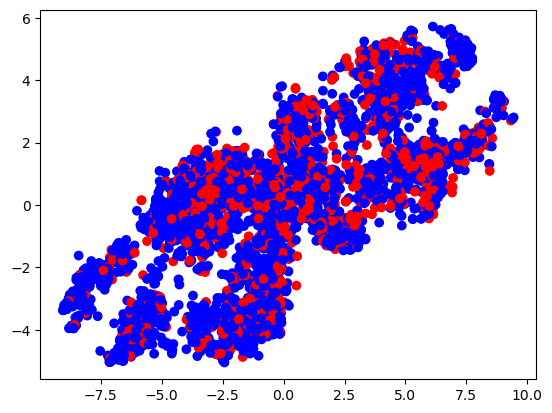

In [7]:
from sklearn.manifold import TSNE
import matplotlib
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(train_data[:5000])
colors= ["blue", "red"]

c = train_labels[:5000].reshape((5000,))
plt.scatter(x=tsne_results[:, 0], y=tsne_results[:, 1], c=c, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

In [8]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

# Helper methods
def print_scores(train_y_true, train_y_preds, test_y_true, test_y_preds):
    train_y_preds_class = np.argmax(train_y_preds, axis=1)
    test_y_preds_class = np.argmax(test_y_preds, axis=1)
    
    print("Train Accuracy {}".format(accuracy_score(train_y_true, train_y_preds_class)))
    print("Test Accuracy {}".format(accuracy_score(test_y_true, test_y_preds_class)))
    
    print("Train ROC AUC {}".format(roc_auc_score(train_y_true, train_y_preds[:, 1])))
    print("Test ROC AUC {}".format(roc_auc_score(test_y_true, test_y_preds[:, 1])))
    
    print("Train F1 Score {}".format(f1_score(train_y_true, train_y_preds_class)))
    print("Test F1 Score {}".format(f1_score(test_y_true, test_y_preds_class)))
    
    print(confusion_matrix(test_labels, test_y_preds_class))
    
    
def plot_curves(labels, preds):
    fig = plt.figure(figsize=(12, 6))
    grid = (1, 2)
    
    ax1 = plt.subplot2grid(grid, (0,0), rowspan=1, colspan=1)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(labels, preds[:, 1])
    ax1.plot([0, 1], [0, 1], linestyle='--') # random
    ax1.plot(fpr, tpr, marker='.')
    ax1.set_title("ROC Curve")
    
    ax2 = plt.subplot2grid(grid, (0,1), rowspan=1, colspan=1)
    # calculate precision recall curve
    precision, recall, thresholds = precision_recall_curve(labels, preds[:, 1])
    ax2.plot(precision, recall, marker='.')
    ax2.set_title("Precision Recall Curve")
    
    plt.show()
    
    

###  XGBoost With One Hot Encoded Features
We begin by experimenting with XGBoost using the one hot encoded features. We can see that the model's performance is
not particularly stellar. The train metrics (AUCROC and accuracy) are decent but the F1 sore is rather subpar. Since the
classes are imbalanced in this dataset, we give preference to the F1 score. We can see that the precision recall curve
and the ROC curve for the test data both show poor results. 

In [9]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


Train Accuracy 0.8502284344325327
Test Accuracy 0.6945901935950787
Train ROC AUC 0.9082128443283994
Test ROC AUC 0.6235065055506777
Train F1 Score 0.6571398985192088
Test F1 Score 0.30190239867659224
[[6948 1097]
 [2279  730]]


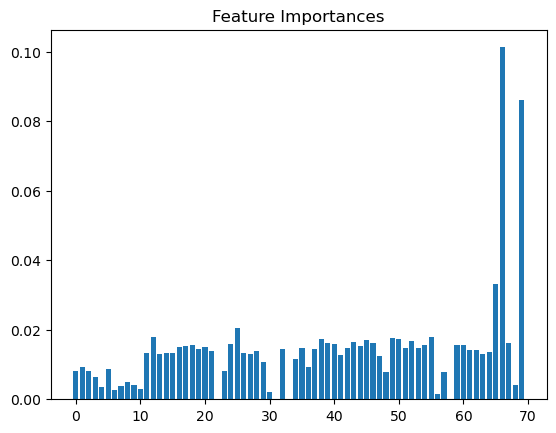

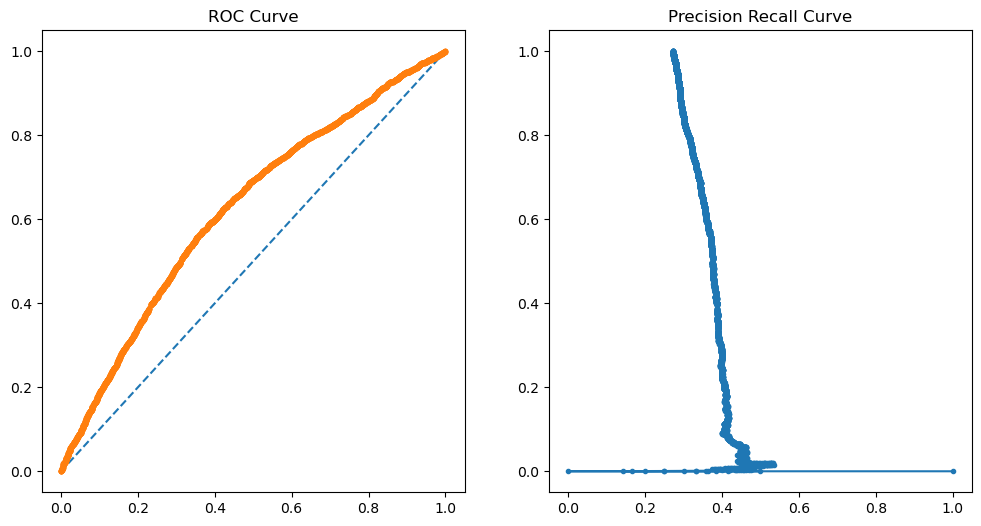

In [10]:
from xgboost import XGBClassifier
model = XGBClassifier(max_depth=10, n_estimators=500, n_jobs=-1)
model.fit(train_data, train_labels)

train_preds = model.predict_proba(train_data)
test_preds = model.predict_proba(test_data)

print_scores(train_labels, train_preds, test_labels, test_preds)

plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title("Feature Importances")
plt.show()

plot_curves(test_labels, test_preds)

###  Random Forest With One Hot Encoded Features
Next we experiment with a Random Forest model using our one hot encoded features. We can see that the model is even
worse than the XGBoost model. We can see that the scores for the test and train set are about equal, suggesting that we
could potentially expand the model or train for longer. The F1 scores however are quite abysmal, which is not promising
being that we are using the F1 score as our primary metric. We can see that the model is struggling with false negatives
based on the confusion matrix, so it is struggling to identify hard drug users, suggesting a similar case to what t-sne
showed us, the data is heavily mixed.

C:\Users\dashi\AppData\Local\Temp\ipykernel_30440\3036291008.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_data, train_labels)


Train Accuracy 0.7336364047586738
Test Accuracy 0.7291478197937398
Train ROC AUC 0.7280110891977097
Test ROC AUC 0.6877921652486088
Train F1 Score 0.033800968085979155
Test F1 Score 0.020287958115183247
[[8029   16]
 [2978   31]]


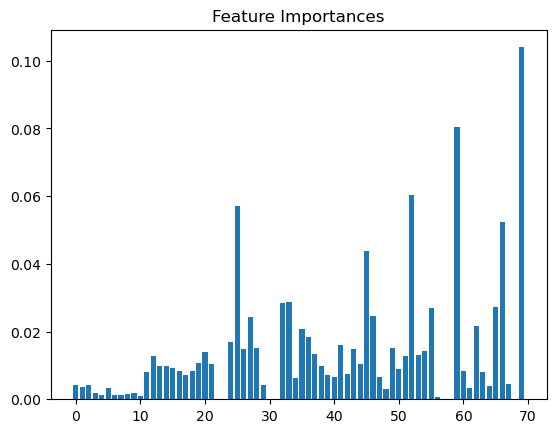

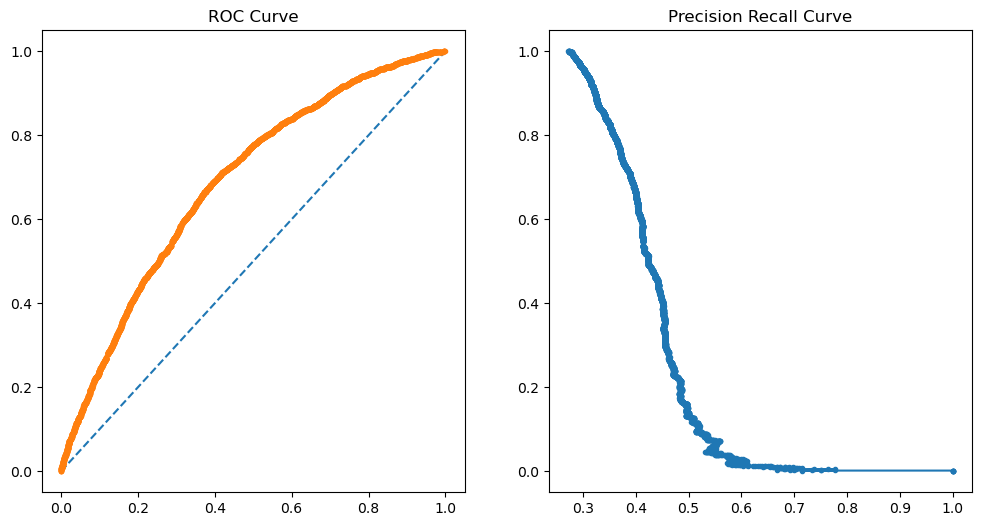

In [11]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=10, n_estimators=500, n_jobs=-1)
model.fit(train_data, train_labels)

train_preds = model.predict_proba(train_data)
test_preds = model.predict_proba(test_data)

print_scores(train_labels, train_preds, test_labels, test_preds)

plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title("Feature Importances")
plt.show()

plot_curves(test_labels, test_preds)

## Raw Feature Models
In our analysis, we initially experimented with one-hot encoding our categorical features. However, the performance of the models using these one-hot encoded features was rather disappointing. 

As a result, we decide to explore an alternative approach by utilizing the raw features directly. By using the raw features without applying one-hot encoding, we aim to capture any potential patterns and relationships that might have been lost or distorted through the one-hot encoding process.

This shift towards raw feature models presents an opportunity to gain further insights and potentially improve the overall performance of our models. We will carefully analyze and compare the results obtained from these raw feature models with those from the previous one-hot encoded models. This analysis will provide valuable information and inform our final conclusions regarding the most effective feature representation for our specific modeling task.

In [12]:
x = data_selection.values

# shuffle the data
order = np.arange(x.shape[0])
np.random.shuffle(order)
x = x[order]
y = labels[order]

train_data = x[:int(x.shape[0] * 0.8)]
test_data = x[int(x.shape[0] * 0.8):]

train_labels = y[:int(x.shape[0] * 0.8)]
test_labels = y[int(x.shape[0] * 0.8):]

###  XGBoost With Raw Features
We can see that XGBoost performs slightly better using the raw features, nothing stellar, but a few points gain on some
of our metrics.

Train Accuracy 0.8574433437372778
Test Accuracy 0.6943187986249322
Train ROC AUC 0.9192362876905906
Test ROC AUC 0.6126532887563908
Train F1 Score 0.6809738320595233
Test F1 Score 0.3045894216917061
[[6935 1118]
 [2261  740]]


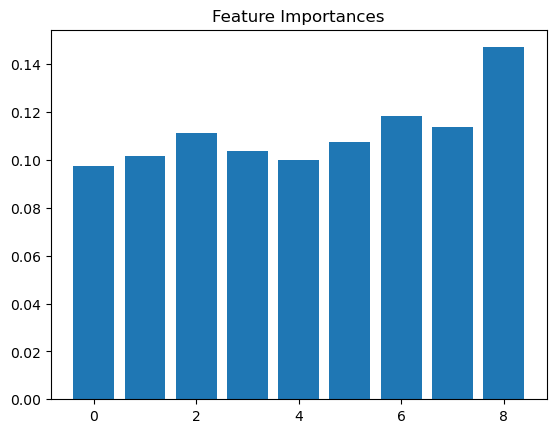

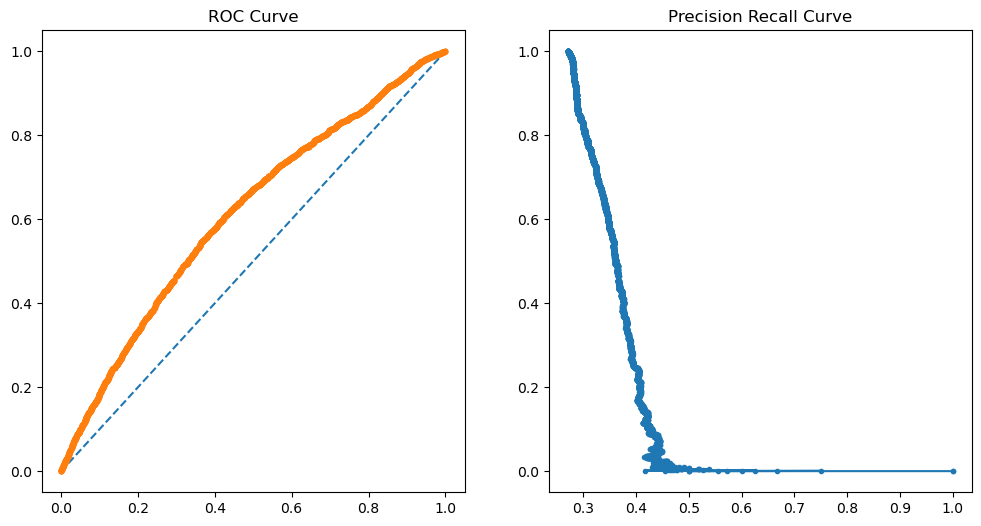

In [13]:
model = XGBClassifier(max_depth=10, n_estimators=500, n_jobs=-1)
model.fit(train_data, train_labels)

train_preds = model.predict_proba(train_data)
test_preds = model.predict_proba(test_data)

print_scores(train_labels, train_preds, test_labels, test_preds)

plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title("Feature Importances")
plt.show()

plot_curves(test_labels, test_preds)

###  Random Forest With Raw Features

We can see that the Random Forest improved rather substantially in F1 score using the raw features over the one hot
features. This still doesn't compete with XGBoost, but it is at least an improvement.

C:\Users\dashi\AppData\Local\Temp\ipykernel_30440\2510894793.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_data, train_labels)


Train Accuracy 0.7503505676934907
Test Accuracy 0.7332187443459381
Train ROC AUC 0.7484318431620351
Test ROC AUC 0.6879429403328573
Train F1 Score 0.18826297984997792
Test F1 Score 0.13034503096431732
[[7884  169]
 [2780  221]]


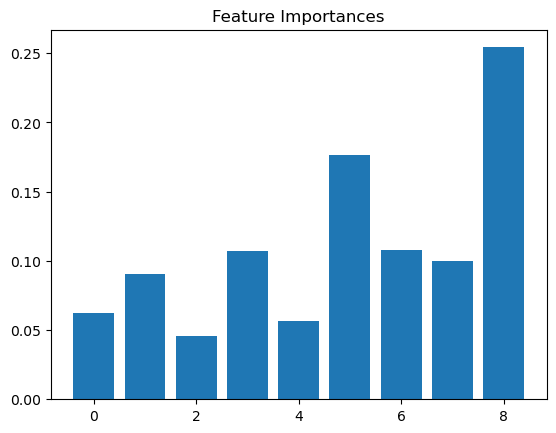

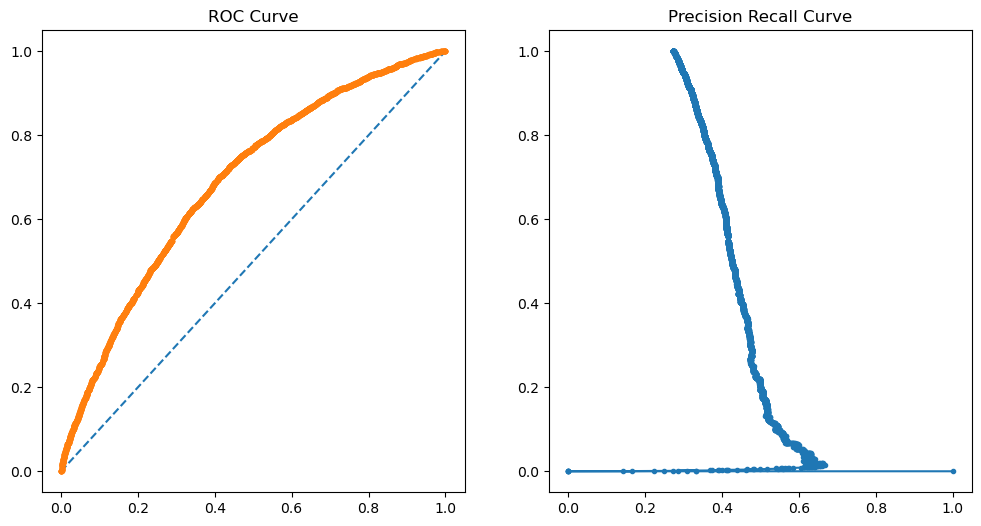

In [14]:
model = RandomForestClassifier(max_depth=10, n_estimators=500, n_jobs=-1)
model.fit(train_data, train_labels)

train_preds = model.predict_proba(train_data)
test_preds = model.predict_proba(test_data)

print_scores(train_labels, train_preds, test_labels, test_preds)

plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title("Feature Importances")
plt.show()

plot_curves(test_labels, test_preds)

## Over Sampling Data Models (ADASYN)
Since we have such a large class imbalance in the dataset, one possible way for correcting for it is using a methods
called over sampling. Over sampling tries to generate more samples close to the minority class examples in an attempt
to create more minority points, helping to correct for the class imbalance. Two common methods of over sampling are SMOTE
and ADASYN. SMOTE finds the k-nearest neighbors in the minority class for each of the samples in the  class, then draws 
lines to the neighbors an generates random points on those lines. ADASYN is simply an improved version of SMOTE. After 
creating those sample it adds a small amount of noise to the points, making it more realistic.

Below we can see that our class balances have been corrected to ~50/50. We also again try experimenting with one hotting
the data.

In [15]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [16]:
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Separate the data into train and test
x = data_selection.values
train_data = x[:int(x.shape[0] * 0.8)]
test_data = x[int(x.shape[0] * 0.8):]

train_labels = labels[:int(x.shape[0] * 0.8)]
test_labels = labels[int(x.shape[0] * 0.8):]

# Only perform ADASYN on the train data (prevents test set contamination)
sm = ADASYN()
train_data, train_labels = sm.fit_resample(train_data, train_labels)

# One-hot encode the data
onehotencoder = OneHotEncoder(categories='auto')
train_data = onehotencoder.fit_transform(train_data).toarray()
test_data = onehotencoder.transform(test_data).toarray()

# Shuffle the data
order = np.arange(train_data.shape[0])
np.random.shuffle(order)
train_data = train_data[order]
train_labels = train_labels[order]

test_labels = np.reshape(test_labels, (test_labels.shape[0], 1))

unique, counts = np.unique(train_labels, return_counts=True)
print("Train Label Counts")
print(dict(zip(unique, counts)))
print(f"{unique[0]}: {round(counts[0]/sum(counts)*100, 3)}%")
print(f"{unique[1]}: {round(counts[1]/sum(counts)*100, 3)}%")

unique, counts = np.unique(test_labels, return_counts=True)
print("Test Label Counts")
print(dict(zip(unique, counts)))
print(f"{unique[0]}: {round(counts[0]/sum(counts)*100, 3)}%")
print(f"{unique[1]}: {round(counts[1]/sum(counts)*100, 3)}%")


Train Label Counts
{0.0: 32186, 1.0: 33778}
0.0: 48.793%
1.0: 51.207%
Test Label Counts
{0.0: 8130, 1.0: 2924}
0.0: 73.548%
1.0: 26.452%


### Visualizing the Data
We can see that the data is much more clustered this time, perhaps this is due to the nature of using nearest neighbors
to generate points close to each other.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.383s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.664879
[t-SNE] KL divergence after 300 iterations: 3.084997


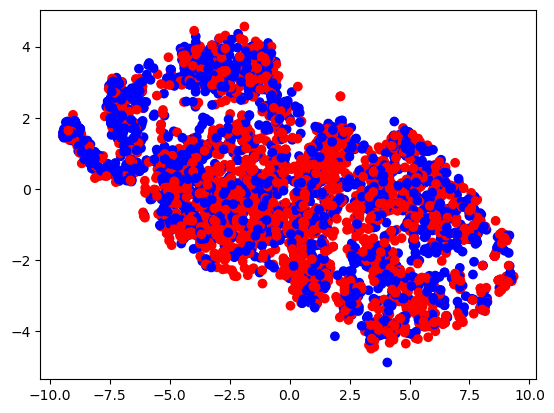

In [17]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(train_data[:5000])
colors= ["blue", "red"]

c = train_labels[:5000].reshape((5000,))
plt.scatter(x=tsne_results[:, 0], y=tsne_results[:, 1], c=c, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

###  XGBoost With ADASYN One-Hot
Experimenting with XGBoost again, we can see that while the accuracy of the model dropped, it maintained the ROCAUC 
score in greatly improved the F1 scores, both on train and test. This is s very promising result as it suggests that
XGBoost is learning more robust features.

Train Accuracy 0.8094263537687223
Test Accuracy 0.6084675230685724
Train ROC AUC 0.9026988937314618
Test ROC AUC 0.6086700513037963
Train F1 Score 0.8220841530209321
Test F1 Score 0.4249269200106298
[[5127 3003]
 [1325 1599]]


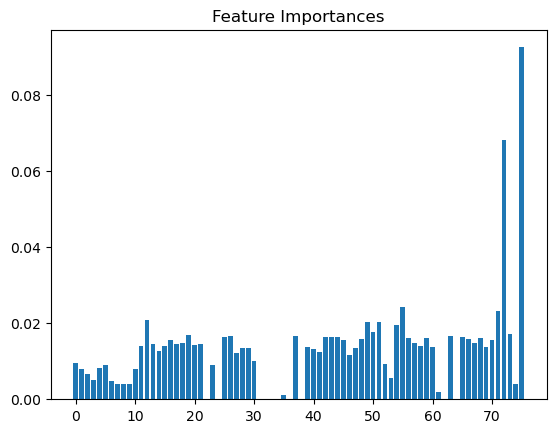

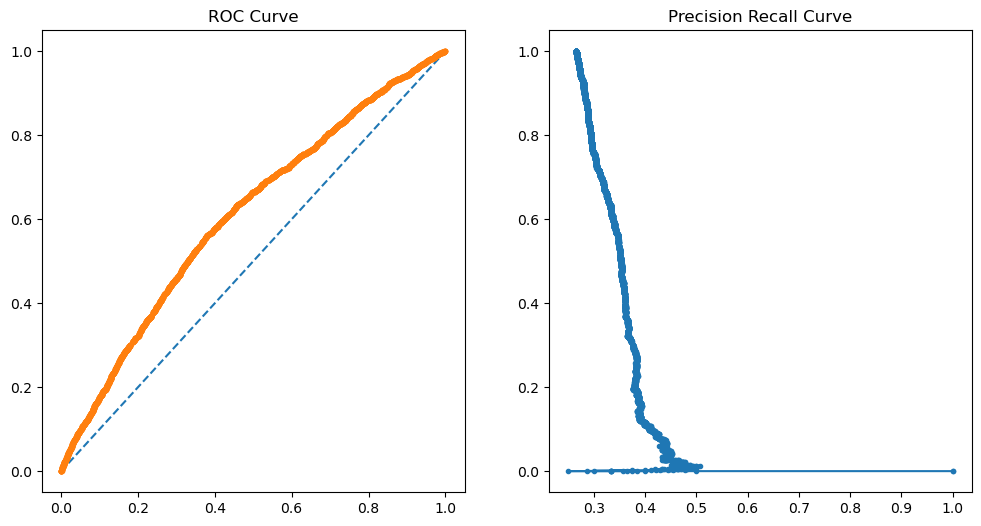

In [18]:
model = XGBClassifier(max_depth=10, n_estimators=500, n_jobs=-1)
model.fit(train_data, train_labels)

train_preds = model.predict_proba(train_data)
test_preds = model.predict_proba(test_data)

print_scores(train_labels, train_preds, test_labels, test_preds)

plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title("Feature Importances")
plt.show()

plot_curves(test_labels, test_preds)

###  Random Forest with ADASYN One-Hot
Experimenting with the Random Forest again, we can see that while the accuracy of the model dropped similar to XGBoost,
but also maintained the ROCAUC score in again substantially improved the F1 scores, even better than our raw features in
the first section.

Train Accuracy 0.6571463222363714
Test Accuracy 0.594807309571196
Train ROC AUC 0.7149107688374632
Test ROC AUC 0.6737798311635645
Train F1 Score 0.6871403275785746
Test F1 Score 0.4744808166138684
[[4553 3577]
 [ 902 2022]]


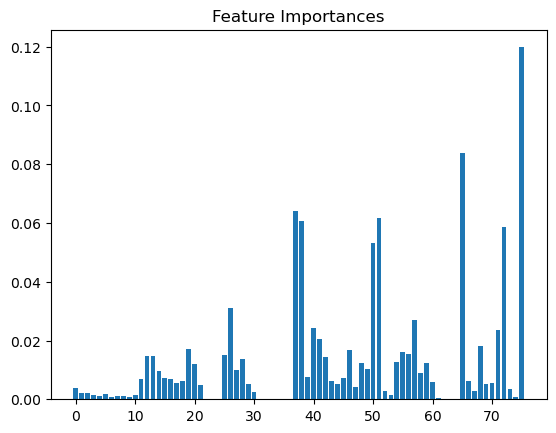

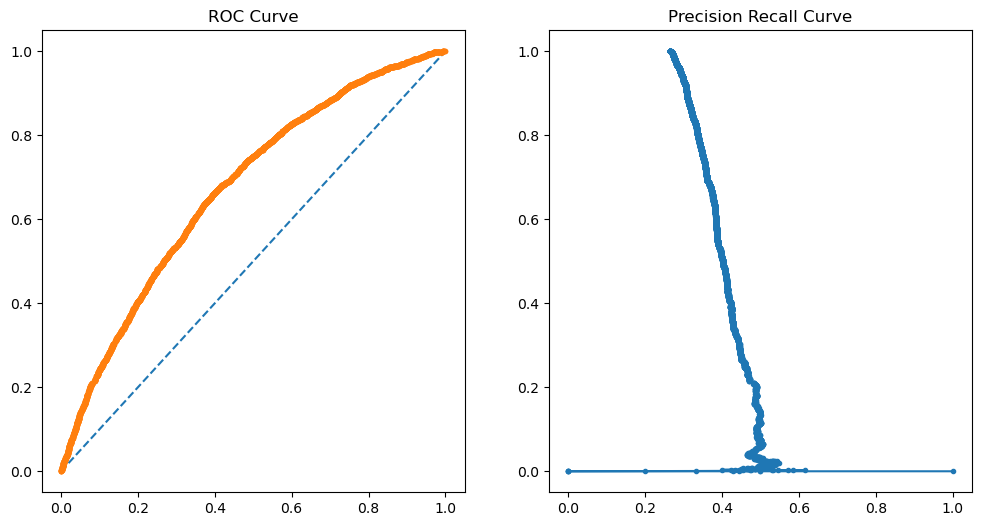

In [19]:
model = RandomForestClassifier(max_depth=10, n_estimators=500, n_jobs=-1)
model.fit(train_data, train_labels)

train_preds = model.predict_proba(train_data)
test_preds = model.predict_proba(test_data)

print_scores(train_labels, train_preds, test_labels, test_preds)

plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title("Feature Importances")
plt.show()

plot_curves(test_labels, test_preds)